In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

version_names = {
    'cpp-1': 'C++-1core',
    'cpp-8': 'C++-8core',
    'numba_par-1': 'Numba-1core',
    'numba_par-8': 'Numba-8core',
}

bench_names = {
    'drift': 'Drift',
    'kick': 'Kick',
    'histo_v5': 'Histo',
    'lik': 'Interp Kick',
    'lik_v2': 'LIK_v2',
    'lik_v3': 'Interp Kick',
}

colors = {
    'cpp-1': 'xkcd:light blue',
    'cpp-8': 'xkcd:light blue',
    'numba_par-1': 'xkcd:light orange',
    'numba_par-8': 'xkcd:light orange',
}

hatches = {
    'cpp-1': '',
    'cpp-8': 'xx',
    'numba_par-1': '',
    'numba_par-8': 'xx',
}



In [61]:
data_file = 'results/results-2023-09-15-kick-drift-lik-histo-v2.csv'

df = pd.read_csv(data_file, sep='\t', header=0)
df = df.drop(columns=['n_rf'])
print(df.shape)
print(df.head())

# # remove rows with suite == 'numba_par', benchmar == 'histo' or 'histo_v1' and n_thr > 1
# df = df[~((df['suite'] == 'numba_par') & (df['benchmark'].isin(['histo', 'histo_v1'])) & (df['n_thr'] > 1))]
# print(df.shape)

# drop rows with suite == 'cpp' and benchmark == 'lik' or 'lik_v2'
df = df[~((df['suite'] == 'cpp') & (df['benchmark'].isin(['lik', 'lik_v2'])))]

# # drop numba histo_v0, histo_v1 for threads> 1
# df = df[~((df['suite'] == 'numba') & (df['benchmark'].isin(['histo_v0', 'histo_v1'])) & (df['n_thr'] > 1))]

# # drop cpp histo_v3, histo_v4, histo_v5
# df = df[~((df['suite'] == 'cpp') & (df['benchmark'].isin(['histo_v3', 'histo_v4', 'histo_v5'])))]

mean_df = df.groupby(['suite', 'benchmark', 'particles', 'slices', 'n_thr']).mean()
print(mean_df.head())


(360, 9)
       suite benchmark  avg(ms)    std     min      max  particles  slices  \
0  numba_par      kick   13.544  0.113  13.427   13.939    1000000     128   
1        cpp      kick    3.200  0.241   3.046    5.420    1000000     128   
2  numba_par      kick  103.094  7.355  99.673  162.026    8000000    1024   
3        cpp      kick   24.517  0.298  24.003   25.214    8000000    1024   
4  numba_par      kick   13.690  0.698  13.410   19.822    1000000     128   

   n_thr  
0      1  
1      1  
2      1  
3      1  
4      1  
                                        avg(ms)     std      min      max
suite benchmark particles slices n_thr                                   
cpp   drift     1000000   128    1       2.4362  0.3457   1.6776   3.3178
                                 8       0.8138  0.9178   0.4110   7.3698
                8000000   1024   1      17.5499  2.3870  12.3734  23.1914
                                 8       3.8262  2.5095   2.7295  22.6040
      histo_

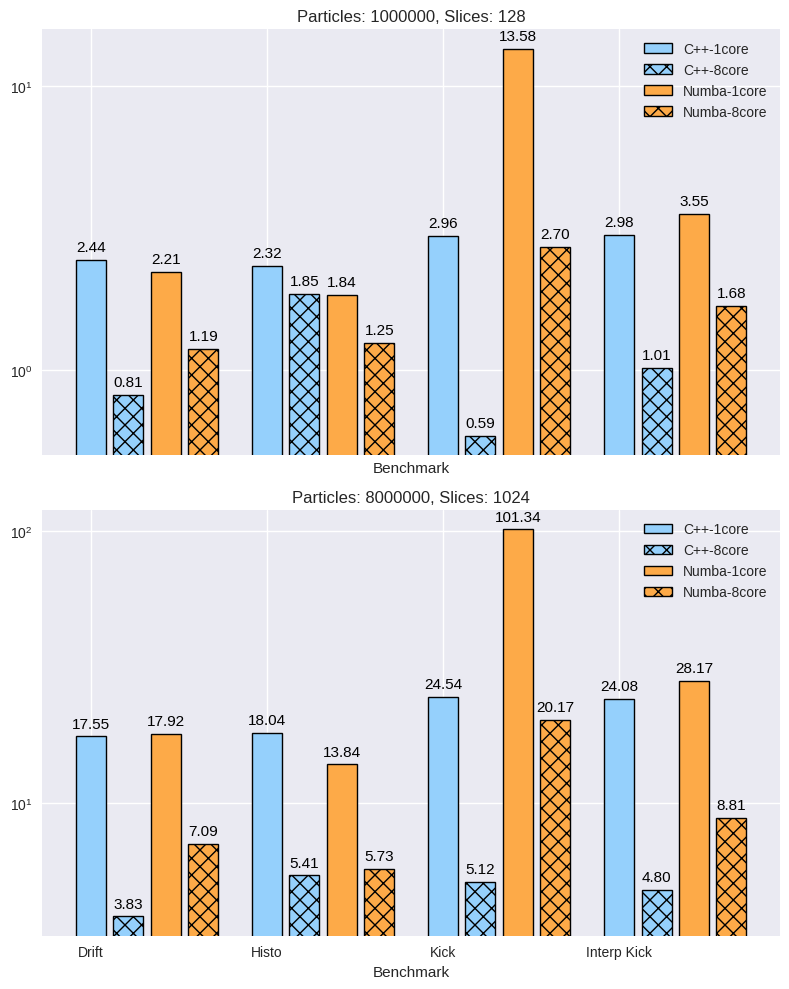

In [62]:
particles_lst = mean_df.index.unique(level='particles').to_list()
slices_lst = mean_df.index.unique(level='slices').to_list()
# n_thr_lst = mean_df.index.unique(level='n_thr').to_list()
bench_lst = mean_df.index.unique(level='benchmark').to_list()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), sharex=True, sharey=False)

for n_particles, n_slices, ax in zip([1000000, 8000000], [128, 1024], axes.flat):
    plt.sca(ax)

    offset = 0
    xticks = []
    xlabels = []
    labels = set()

    for bench in bench_lst:

        temp_df = mean_df.loc[(mean_df.index.get_level_values('particles') == n_particles) &
                       (mean_df.index.get_level_values('slices') == n_slices) &
                       (mean_df.index.get_level_values('benchmark') == bench)]
        
        suite = temp_df.index.get_level_values('suite').to_list()
        thread = temp_df.index.get_level_values('n_thr').to_list()

        keys = [f'{suite}-{thread}' for suite, thread in zip(suite, thread)]

        n_vals = len(temp_df)
        y = temp_df['avg(ms)']
        yerr = temp_df['std']
        ymin = temp_df['min']
        ymax = temp_df['max']
        x = np.arange(offset, offset + n_vals).tolist()

        # xlabels += [version_names[k] for k in keys]
        xlabels += [bench_names[bench]]
        xticks += [x[0]]

        # create barplot with errors
        for xi, yi, yerri, key in zip(x, y, yerr, keys):
            if key in labels:
                label = None
            else:
                label = version_names[key]
                labels.add(key)

            plt.bar(xi, yi, width=0.8, 
                    # yerr=[np.minimum(yerri, yi)], 
                    color=colors[key], edgecolor='black', linewidth=1,
                    hatch=hatches[key], label=label)

            plt.annotate(f'{yi:.2f}', xy=(xi, 1.05*yi), ha='center',
                            va='bottom', fontsize=11, color='black',
                            rotation=0)

        offset += n_vals+0.7
        if bench == bench_lst[-2]:
            offset -= 0.7

    # xlabels = [i.replace('-histo', '').replace('_par', '') for i in xlabels]

    # enable y grid lines
    ax.set_yscale('log')
    plt.title(f'Particles: {n_particles}, Slices: {n_slices}')
    plt.xlabel('Benchmark')
    # plt.grid(axis='y')
    plt.xticks(xticks[:-1], xlabels[:-1], rotation=0)
    plt.legend()
    plt.tight_layout()


plt.savefig('plots/bars-time-suites-benchmarks-threads.png', bbox_inches='tight')
plt.show()




# Conclusions
* 1-core Numba matches the performance or outperforms C++ in 3/4 cases (except kick)
* 8-cores C++ is clearly faster by ~1 - 2x (except kick that we see ~4x)
* kick uses the higly optimized vector math library, this is why it outperforms numba by that much
* With numba and minimal effort we can get a decent speedup compared to numpy
* Can also match the C++ performance in many cases if carefully optimized
* C++ offers greater flexibility, integration with 3rd party libraries, better at parallel execution